In [1]:
import copy

import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# 自定义类，用于封装tif文件的操作
class TifFile:
    def __init__(self, file_path):
        self.file_path = file_path
        with rasterio.open(self.file_path) as src:
            self.data = src.read(1)  # 数值矩阵
            self.shape = self.data.shape  # 矩阵大小
            self.transform = src.transform  # 坐标变换参数
            self.crs = src.crs  # 坐标参考系统
            self.bounds = src.bounds  # 边界坐标
            self.width = src.width  # 宽度
            self.height = src.height  # 高度
            self.count = src.count  # 波段数


# 文件路径字典
file_paths = {
    "GLcBld_Height": "datasets/GLcBld_Height.tif",
    "glcent_CHM": "datasets/glcent_CHM.tif",
    "glcent_DSM": "datasets/glcent_DSM.tif",
    "KernelD_GLcB_new": "datasets/KernelD_GLcB_new.tif",
    "LAI": "datasets/LAI.tif"
}

# 动态创建TifFile实例并存储为全局变量
for variable_name, file_path in file_paths.items():
    tif_GLcBld_Height = TifFile('datasets/GLcBld_Height.tif')
    tif_glcent_CHM = TifFile('datasets/glcent_CHM.tif')
    tif_glcent_DSM = TifFile('datasets/glcent_DSM.tif')
    tif_KernelD_GLcB_new = TifFile('datasets/KernelD_GLcB_new.tif')
    tif_LAI = TifFile('datasets/LAI.tif')


# 数据信息了解

In [3]:
tif_GLcBld_Height.data

array([[65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       ...,
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16)

In [4]:
# 计算每个唯一值的数量
unique_values, counts = np.unique(tif_GLcBld_Height.data, return_counts=True)

# 根据计数进行排序，倒序排列
sorted_indices = np.argsort(counts)[::-1]

# 使用排序后的索引重新排序唯一值和计数
sorted_unique_values = unique_values[sorted_indices]
sorted_counts = counts[sorted_indices]

# 打印倒序的结果
for value, count in zip(sorted_unique_values, sorted_counts):
    print(f"Value: {value}, Count: {count}")

Value: 65535, Count: 139282
Value: 109, Count: 1798
Value: 249, Count: 1338
Value: 294, Count: 1312
Value: 3, Count: 1113
Value: 205, Count: 822
Value: 342, Count: 698
Value: 96, Count: 584
Value: 340, Count: 552
Value: 154, Count: 534
Value: 315, Count: 528
Value: 195, Count: 510
Value: 232, Count: 497
Value: 299, Count: 482
Value: 268, Count: 479
Value: 233, Count: 473
Value: 170, Count: 437
Value: 104, Count: 433
Value: 110, Count: 421
Value: 215, Count: 394
Value: 280, Count: 380
Value: 75, Count: 376
Value: 269, Count: 374
Value: 175, Count: 374
Value: 210, Count: 370
Value: 243, Count: 357
Value: 67, Count: 346
Value: 40, Count: 345
Value: 140, Count: 343
Value: 30, Count: 340
Value: 333, Count: 339
Value: 157, Count: 335
Value: 98, Count: 335
Value: 139, Count: 331
Value: 270, Count: 321
Value: 242, Count: 321
Value: 145, Count: 319
Value: 106, Count: 319
Value: 39, Count: 317
Value: 63, Count: 315
Value: 180, Count: 313
Value: 16, Count: 308
Value: 244, Count: 305
Value: 21, Co

In [5]:
# 计算基本统计数据（此部分与前面代码相同）
mean_value = np.mean(tif_GLcBld_Height.data)
std_dev = np.std(tif_GLcBld_Height.data)
min_value = np.min(tif_GLcBld_Height.data)
max_value = np.max(tif_GLcBld_Height.data)

print("\nBasic Statistics:")
print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")


Basic Statistics:
Mean: 47696.188133956304
Standard Deviation: 29118.9257780749
Min: 1
Max: 65535


In [6]:
tif_GLcBld_Height.transform

Affine(5.0, 0.0, 257976.73599999957,
       0.0, -5.0, 666174.3099000007)

In [7]:
tif_GLcBld_Height.crs

CRS.from_epsg(27700)

In [8]:
tif_GLcBld_Height.bounds

BoundingBox(left=257976.73599999957, bottom=663899.3099000007, right=260081.73599999957, top=666174.3099000007)

In [9]:
tif_GLcBld_Height.width

421

In [10]:
tif_GLcBld_Height.height

455

In [11]:
tif_GLcBld_Height.count

1

In [12]:
tif_glcent_CHM.data

array([[28.882736  , 28.408676  , 27.841417  , ..., 15.216122  ,
        14.058662  ,  0.08586502],
       [31.331669  , 30.637243  , 31.719954  , ..., 13.888069  ,
        12.631687  ,  0.07413864],
       [31.908613  , 31.804506  , 32.027122  , ..., 10.486404  ,
         9.954441  ,  0.0562439 ],
       ...,
       [ 6.266613  ,  6.3237047 ,  1.4739332 , ..., 17.83626   ,
        18.70651   , 17.208393  ],
       [ 4.7787457 ,  1.4792271 ,  0.1911993 , ..., 12.996392  ,
        14.958178  , 18.35652   ],
       [ 0.25867653,  0.15101147,  0.16328621, ...,  0.0835458 ,
         0.13466549, 12.975633  ]], dtype=float32)

In [13]:
tif_list = [tif_GLcBld_Height, tif_glcent_CHM, tif_glcent_DSM, tif_KernelD_GLcB_new, tif_LAI]

# 创建一个空的列表，用于存储每个tif文件的属性
data = []

# 遍历每个TifFile对象，提取属性并存储到data列表中
data = [
    {
        "Name": tif.file_path.split('/')[-1],  # 提取文件名
        "Data": tif.data,
        "Data.shape": tif.shape,
        "Transform": tif.transform,
        "CRS": tif.crs,
        "Bounds": tif.bounds,
        "Width": tif.width,
        "Height": tif.height,
        "Band Count": tif.count
    }
    for tif in tif_list
]

# 将列表转换为DataFrame
df = pd.DataFrame(data)


In [14]:
df

,Name,Data,Data.shape,Transform,CRS,Bounds,Width,Height,Band Count
0,GLcBld_Height.tif,"[[65535, 65535, 65535, 65535, 65535, 65535, 65...","(455, 421)","(5.0, 0.0, 257976.73599999957, 0.0, -5.0, 6661...",(init),"(257976.73599999957, 663899.3099000007, 260081...",421,455,1
1,glcent_CHM.tif,"[[28.882736, 28.408676, 27.841417, 2.758522, 0...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
2,glcent_DSM.tif,"[[55.24, 54.737, 54.116, 28.998, 26.305, 36.85...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
3,KernelD_GLcB_new.tif,"[[244.3018, 275.4633, 306.76352, 337.6687, 367...","(245, 244)","(8.21323320000243, 0.0, 257999.8617497996, 0.0...",(init),"(257999.8617497996, 663991.944182601, 260003.8...",244,245,1
4,LAI.tif,"[[11.7030945, 11.513471, 11.286567, 1.2534088,...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1


In [15]:
A = tif_glcent_CHM
B = tif_GLcBld_Height
transform_A = A.transform
transform_B = B.transform
width_A = A.width
height_A = A.height
width_B = B.width
height_B = B.height

In [16]:
transform_A

Affine(5.0, 0.0, 258000.0,
       0.0, -5.0, 666000.0)

In [17]:
transform_B

Affine(5.0, 0.0, 257976.73599999957,
       0.0, -5.0, 666174.3099000007)

In [18]:
width_A

400

边界计算：
已知信息
A 的仿射变换: Affine(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0)
B 的仿射变换: Affine(5.0, 0.0, 257976.73599999997, 0.0, -5.0, 666174.3099999997)

A 的大小: width_A = 400，height_A = 400
B 的大小: width_B = 421，height_B = 455

计算边界（Bounding Box）
我们需要计算两个图像的空间范围（Bounding Box），即确定它们的左上角和右下角的地理坐标。

1. A 的边界
左上角（xmin_A, ymax_A）:
xmin_A = 258000.0
ymax_A = 666000.0
右下角（xmax_A, ymin_A）:
xmax_A = 258000.0 + 400 * 5.0 = 260000.0
ymin_A = 666000.0 + 400 * -5.0 = 664000.0
因此，A 的边界是：

(xmin_A, ymin_A, xmax_A, ymax_A) = (258000.0, 664000.0, 260000.0, 666000.0)
2. B 的边界
左上角（xmin_B, ymax_B）:
xmin_B = 257976.736
ymax_B = 666174.31
右下角（xmax_B, ymin_B）:
xmax_B = 257976.736 + 421 * 5.0 = 260081.736
ymin_B = 666174.31 + 455 * -5.0 = 663899.81
因此，B 的边界是：

(xmin_B, ymin_B, xmax_B, ymax_B) = (257976.736, 663899.81, 260081.736, 666174.31)

B完全覆盖A

In [19]:
# 读取 B 的文件
with rasterio.open('datasets/GLcBld_Height.tif') as src_B:
    # A 的边界
    xmin_A, ymin_A, xmax_A, ymax_A = 258000.0, 664000.0, 260000.0, 666000.0

    # 计算 B 中与 A 重叠的窗口
    window = from_bounds(xmin_A, ymin_A, xmax_A, ymax_A, transform=src_B.transform)

    # 获取窗口的行列偏移和大小
    col_off, row_off = window.col_off, window.row_off
    width, height = window.width, window.height

    # 打印裁剪范围相对于原始 B 图像的行列范围
    print(f"裁剪范围在原始 B 图像中的列偏移: {col_off}, 行偏移: {row_off}")
    print(f"裁剪范围的宽度: {width} 像素，高度: {height} 像素")
    print(f"裁剪范围结束的列号: {col_off + width}, 行号: {row_off + height}")

    # 读取窗口内的 B 的数据
    B_overlap_data = src_B.read(window=window)

    # 生成裁剪后的 B 数据
    profile = src_B.profile
    profile.update({
        "height": window.height,
        "width": window.width,
        "transform": rasterio.windows.transform(window, src_B.transform)
    })


裁剪范围在原始 B 图像中的列偏移: 4.652800000083516, 行偏移: 34.86198000013246
裁剪范围的宽度: 400.0 像素，高度: 400.0 像素
裁剪范围结束的列号: 404.6528000000835, 行号: 434.86198000013246


In [20]:
B_overlap_data

array([[[  181, 65535, 65535, ..., 65535, 65535, 65535],
        [  181,   181,   181, ..., 65535, 65535, 65535],
        [  181,   181,   181, ..., 65535, 65535, 65535],
        ...,
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535]]], dtype=uint16)

In [21]:
C = B_overlap_data[0, :, :]

In [22]:
CHM_tif = copy.deepcopy(tif_glcent_CHM)
DSM_tif = copy.deepcopy(tif_glcent_DSM)
LAI_tif = copy.deepcopy(tif_LAI)
BH_tif = copy.deepcopy(tif_glcent_CHM)

In [23]:
BH_tif

In [24]:
BH_tif.data

array([[28.882736  , 28.408676  , 27.841417  , ..., 15.216122  ,
        14.058662  ,  0.08586502],
       [31.331669  , 30.637243  , 31.719954  , ..., 13.888069  ,
        12.631687  ,  0.07413864],
       [31.908613  , 31.804506  , 32.027122  , ..., 10.486404  ,
         9.954441  ,  0.0562439 ],
       ...,
       [ 6.266613  ,  6.3237047 ,  1.4739332 , ..., 17.83626   ,
        18.70651   , 17.208393  ],
       [ 4.7787457 ,  1.4792271 ,  0.1911993 , ..., 12.996392  ,
        14.958178  , 18.35652   ],
       [ 0.25867653,  0.15101147,  0.16328621, ...,  0.0835458 ,
         0.13466549, 12.975633  ]], dtype=float32)

In [25]:
B_overlap_data.shape

(1, 400, 400)

In [26]:

BH_tif.data = C
BH_tif.shape = C.shape

In [27]:
BH_tif.data

array([[  181, 65535, 65535, ..., 65535, 65535, 65535],
       [  181,   181,   181, ..., 65535, 65535, 65535],
       [  181,   181,   181, ..., 65535, 65535, 65535],
       ...,
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16)

In [28]:
list_tif = [
    BH_tif,  # 建筑物高度
    CHM_tif,  # 树冠高度
    LAI_tif,  # 叶面积指数
    DSM_tif  # 地形数据   
]

data1 = []

# 遍历每个TifFile对象，提取属性并存储到data列表中
data1 = [
    {
        "Name": tif.file_path.split('/')[-1],  # 提取文件名
        "Data": tif.data,
        "Data.shape": tif.shape,
        "Transform": tif.transform,
        "CRS": tif.crs,
        "Bounds": tif.bounds,
        "Width": tif.width,
        "Height": tif.height,
        "Band Count": tif.count
    }
    for tif in list_tif
]

In [29]:
df = pd.DataFrame(data1)

In [30]:
df

,Name,Data,Data.shape,Transform,CRS,Bounds,Width,Height,Band Count
0,glcent_CHM.tif,"[[181, 65535, 65535, 65535, 65535, 65535, 6553...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
1,glcent_CHM.tif,"[[28.882736, 28.408676, 27.841417, 2.758522, 0...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
2,LAI.tif,"[[11.7030945, 11.513471, 11.286567, 1.2534088,...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
3,glcent_DSM.tif,"[[55.24, 54.737, 54.116, 28.998, 26.305, 36.85...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1


In [31]:
list_tifs = [BH_tif.data, CHM_tif.data, LAI_tif.data, DSM_tif.data]

In [32]:
list_tifs

[array([[  181, 65535, 65535, ..., 65535, 65535, 65535],
        [  181,   181,   181, ..., 65535, 65535, 65535],
        [  181,   181,   181, ..., 65535, 65535, 65535],
        ...,
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16),
 array([[28.882736  , 28.408676  , 27.841417  , ..., 15.216122  ,
         14.058662  ,  0.08586502],
        [31.331669  , 30.637243  , 31.719954  , ..., 13.888069  ,
         12.631687  ,  0.07413864],
        [31.908613  , 31.804506  , 32.027122  , ..., 10.486404  ,
          9.954441  ,  0.0562439 ],
        ...,
        [ 6.266613  ,  6.3237047 ,  1.4739332 , ..., 17.83626   ,
         18.70651   , 17.208393  ],
        [ 4.7787457 ,  1.4792271 ,  0.1911993 , ..., 12.996392  ,
         14.958178  , 18.35652   ],
        [ 0.25867653,  0.15101147,  0.16328621, ...,  0.0835458 ,
          0.13466549, 12.975633  ]], dty

# 网格数据差值

In [33]:
# 已知点的坐标和温度值
points = np.array([
    [0, 0],  # 点 A
    [1, 0],  # 点 B
    [0, 1]   # 点 C
])

temperatures = np.array([5, 6, 7])  # 点 A, B, C 的温度值

# 半变异矩阵
Gamma = np.array([
    [0, 1, 1, 1],          # 点 A 到 A, B, C 和约束条件
    [1, 0, np.sqrt(2), 1], # 点 B 到 A, B, C 和约束条件
    [1, np.sqrt(2), 0, 1], # 点 C 到 A, B, C 和约束条件
    [1, 1, 1, 0]           # 约束条件
])

# 目标点 P 的坐标
P = np.array([0.5, 0.5])

# 计算 P 到 A, B, C 的半变异函数值
gamma = np.array([
    np.sqrt(np.sum((P - points[0])**2)),  # 到 A 的距离
    np.sqrt(np.sum((P - points[1])**2)),  # 到 B 的距离
    np.sqrt(np.sum((P - points[2])**2)),  # 到 C 的距离
    1  # 约束条件
])

# 解克里金系统
lambdas = np.linalg.solve(Gamma, gamma)

# 提取权重
lambda_A, lambda_B, lambda_C, mu = lambdas

# 使用权重计算插值点 P 的温度值
Z_P = lambda_A * temperatures[0] + lambda_B * temperatures[1] + lambda_C * temperatures[2]

print(f"点 P (0.5, 0.5) 的估计温度值为: {Z_P:.2f}")


点 P (0.5, 0.5) 的估计温度值为: 6.16


In [34]:
# 输入6个点的坐标和天气数据值

# 提取的数据如下：
data_5_extra_points = [
    ['Renfrew Weather', (55.8739065, -4.3887910), (250756.73, 666880.47), '31/07/2024 09:30:00', 8.4, 17, 57, 0.4],
    ['Ralston Weather Station', (55.8466298, -4.3708027), (251848.22, 663740.00), '31/07/2024 09:30:00', 8.1, 11.8, 78.2, 0.9],
    ['Cathcart', (55.8114036, -4.2603826), (258548.22, 659684.28), '31/07/2024 09:28:07', 10, 15.9, 68, 0],
    ['Clincarthill', (55.8253972, -4.2119939), (261484.32, 661295.42), '31/07/2024 09:29:36', 9.3, 15.1, 68, 0.8],
    ['Cambuslang Scotland', (55.8253972, -4.2119939), (261484.32, 661295.42), '31/07/2024 09:31:36', 8.9, 13.4, 74, 0]
]

# 直接将数据列表转换为 Pandas DataFrame
columns = ['Location', 'A Coordinates (Lat, Lon)', 'B Coordinates (X_B, Y_B)', 'Report Date / Time', 'Dew Point (°C)', 'Air Temperature (°C)', 'Relative Humidity (%)', 'Wind Speed (kn)']
df_5_extra_points = pd.DataFrame(data_5_extra_points, columns=columns)

# 显示 DataFrame
df_5_extra_points


,Location,"A Coordinates (Lat, Lon)","B Coordinates (X_B, Y_B)",Report Date / Time,Dew Point (°C),Air Temperature (°C),Relative Humidity (%),Wind Speed (kn)
0,Renfrew Weather,"(55.8739065, -4.388791)","(250756.73, 666880.47)",31/07/2024 09:30:00,8.4,17.0,57.0,0.4
1,Ralston Weather Station,"(55.8466298, -4.3708027)","(251848.22, 663740.0)",31/07/2024 09:30:00,8.1,11.8,78.2,0.9
2,Cathcart,"(55.8114036, -4.2603826)","(258548.22, 659684.28)",31/07/2024 09:28:07,10.0,15.9,68.0,0.0
3,Clincarthill,"(55.8253972, -4.2119939)","(261484.32, 661295.42)",31/07/2024 09:29:36,9.3,15.1,68.0,0.8
4,Cambuslang Scotland,"(55.8253972, -4.2119939)","(261484.32, 661295.42)",31/07/2024 09:31:36,8.9,13.4,74.0,0.0


In [35]:
# 从DataFrame中提取B坐标系的点和相关数据
B_points = np.array([item[2] for item in data_5_extra_points])
dew_points = np.array(df_5_extra_points['Dew Point (°C)'])
air_temps = np.array(df_5_extra_points['Air Temperature (°C)'])
humidity = np.array(df_5_extra_points['Relative Humidity (%)'])
wind_speeds = np.array(df_5_extra_points['Wind Speed (kn)'])


In [36]:
B_points

array([[250756.73, 666880.47],
       [251848.22, 663740.  ],
       [258548.22, 659684.28],
       [261484.32, 661295.42],
       [261484.32, 661295.42]])

In [37]:
dew_points

array([ 8.4,  8.1, 10. ,  9.3,  8.9])

In [38]:
air_temps

array([17. , 11.8, 15.9, 15.1, 13.4])

In [39]:
humidity

array([57. , 78.2, 68. , 68. , 74. ])

In [40]:
wind_speeds

array([0.4, 0.9, 0. , 0.8, 0. ])

In [41]:
# 定义网格
x_min, x_max = 258000, 260000
y_min, y_max = 664000, 666000
grid_x, grid_y = np.mgrid[x_min:x_max:400j, y_min:y_max:400j]
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T  # 是一个 (160000, 2) 的数组，保存了所有网格点的 (x, y) 坐标

In [42]:
grid_points

array([[258000.        , 664000.        ],
       [258000.        , 664005.01253133],
       [258000.        , 664010.02506266],
       ...,
       [260000.        , 665989.97493734],
       [260000.        , 665994.98746867],
       [260000.        , 666000.        ]])

In [43]:
# 定义半变异矩阵Gamma，简化处理为欧式距离
def compute_gamma(points, P):
    dist = np.sqrt(np.sum((points - P)**2, axis=1))
    return np.hstack([dist, 1])


In [44]:
# 函数：计算克里金插值
def kriging_interpolation(B_points, values, grid_points):
    # 构造Gamma矩阵
    n_points = len(B_points)
    Gamma = np.ones((n_points + 1, n_points + 1))
    for i in range(n_points):
        for j in range(n_points):
            Gamma[i, j] = np.sqrt(np.sum((B_points[i] - B_points[j])**2))

    # 添加一个小的正数扰动到对角线以避免奇异矩阵
    Gamma[np.diag_indices_from(Gamma)] += 1e-10

    Gamma[-1, -1] = 0

    # 插值结果存储
    interpolated_values = []

    for P in grid_points:
        gamma = compute_gamma(B_points, P)
        lambdas = np.linalg.solve(Gamma, gamma)
        interpolated_value = np.sum(lambdas[:-1] * values)
        interpolated_values.append(interpolated_value)

    return np.array(interpolated_values)


In [45]:
# 对每个变量进行插值
dew_point_grid = kriging_interpolation(B_points, dew_points, grid_points)
air_temp_grid = kriging_interpolation(B_points, air_temps, grid_points)
humidity_grid = kriging_interpolation(B_points, humidity, grid_points)
wind_speed_grid = kriging_interpolation(B_points, wind_speeds, grid_points)


In [46]:
# 将结果存储为DataFrame
grid_df = pd.DataFrame({
    'X': grid_points[:, 0],
    'Y': grid_points[:, 1],
    'Dew Point (°C)': dew_point_grid,
    'Air Temperature (°C)': air_temp_grid,
    'Relative Humidity (%)': humidity_grid,
    'Wind Speed (kn)': wind_speed_grid
})

In [47]:
grid_df

,X,Y,Dew Point (°C),Air Temperature (°C),Relative Humidity (%),Wind Speed (kn)
0,258000.0,664000.000000,8.999907,14.600371,69.439597,0.404868
1,258000.0,664005.012531,8.999255,14.600463,69.436530,0.405059
2,258000.0,664010.025063,8.998604,14.600558,69.433455,0.405249
3,258000.0,664015.037594,8.997953,14.600656,69.430372,0.405438
4,258000.0,664020.050125,8.997304,14.600757,69.427280,0.405627
...,...,...,...,...,...,...
159995,260000.0,665979.949875,8.868125,14.825202,67.820382,0.426470
159996,260000.0,665984.962406,8.867806,14.825854,67.816359,0.426516
159997,260000.0,665989.974937,8.867487,14.826507,67.812334,0.426562
159998,260000.0,665994.987469,8.867168,14.827160,67.808308,0.426608


In [48]:
# 匹配地形数据与天气数据的形状

# 展平地形数据
X = np.array([tif.ravel() for tif in list_tifs]).T # (160000, 4)

In [49]:
X

array([[1.81000000e+02, 2.88827362e+01, 1.17030945e+01, 5.52400017e+01],
       [6.55350000e+04, 2.84086761e+01, 1.15134706e+01, 5.47369995e+01],
       [6.55350000e+04, 2.78414173e+01, 1.12865667e+01, 5.41160011e+01],
       ...,
       [6.55350000e+04, 8.35458040e-02, 1.83418334e-01, 1.90300000e+00],
       [6.55350000e+04, 1.34665489e-01, 2.03866199e-01, 1.94400001e+00],
       [6.55350000e+04, 1.29756327e+01, 5.34025335e+00, 1.47709999e+01]],
      dtype=float32)

In [50]:
# 提取天气数据
Y = grid_df[['Dew Point (°C)', 'Air Temperature (°C)', 'Relative Humidity (%)', 'Wind Speed (kn)']].values # (160000, 4)

In [51]:
Y

array([[ 8.99990701, 14.6003705 , 69.43959655,  0.40486841],
       [ 8.99925483, 14.600463  , 69.43653002,  0.40505876],
       [ 8.99860355, 14.60055833, 69.43345515,  0.40524862],
       ...,
       [ 8.86748666, 14.82650657, 67.81233419,  0.42656228],
       [ 8.86716808, 14.82715992, 67.80830767,  0.42660798],
       [ 8.86684982, 14.82781394, 67.80427948,  0.42665352]])

In [52]:
# # 构建存储结果的表格
# importance_matrix = np.zeros((4, 4))

In [53]:
# from sklearn.ensemble import RandomForestRegressor

In [54]:
# # 对每一个Y参数构建随机森林模型并计算重要性
# for i in range(4):
#     y = Y[:, i]  # 第 i 个 Y 参数
#     model = RandomForestRegressor(n_estimators=100, random_state=42)
#     model.fit(X, y)
#     importance_matrix[:, i] = model.feature_importances_

In [55]:
# # 将结果转化为DataFrame以便显示
# importance_df = pd.DataFrame(importance_matrix,
#                              columns=['Dew Point (°C)', 'Air Temperature (°C)', 'Relative Humidity (%)', 'Wind Speed (kn)'],
#                              index=['建筑物高度', '树冠高度', '叶面积指数', '地形数据'])


In [56]:
# # 显示结果
# importance_df

In [57]:
# 读取数据
X 

array([[1.81000000e+02, 2.88827362e+01, 1.17030945e+01, 5.52400017e+01],
       [6.55350000e+04, 2.84086761e+01, 1.15134706e+01, 5.47369995e+01],
       [6.55350000e+04, 2.78414173e+01, 1.12865667e+01, 5.41160011e+01],
       ...,
       [6.55350000e+04, 8.35458040e-02, 1.83418334e-01, 1.90300000e+00],
       [6.55350000e+04, 1.34665489e-01, 2.03866199e-01, 1.94400001e+00],
       [6.55350000e+04, 1.29756327e+01, 5.34025335e+00, 1.47709999e+01]],
      dtype=float32)

In [58]:
Y

array([[ 8.99990701, 14.6003705 , 69.43959655,  0.40486841],
       [ 8.99925483, 14.600463  , 69.43653002,  0.40505876],
       [ 8.99860355, 14.60055833, 69.43345515,  0.40524862],
       ...,
       [ 8.86748666, 14.82650657, 67.81233419,  0.42656228],
       [ 8.86716808, 14.82715992, 67.80830767,  0.42660798],
       [ 8.86684982, 14.82781394, 67.80427948,  0.42665352]])

In [67]:
# class StoreResultsCallback:
#     def __init__(self, total_iterations, X, Y, model_idx):
#         self.parameters = []
#         self.mse_scores = []
#         self.r2_scores = []
#         self.mae_scores = []
#         self.rmse_scores = []
#         self.mape_scores = []
#         self.X = X
#         self.Y = Y
#         self.model_idx = model_idx
#         self.pbar = tqdm(total=total_iterations, desc=f"BayesSearchCV Iterations for Model {model_idx+1}")
# 
#     def __call__(self, result):
#         self.parameters.append(result.x)  # 储存当前参数
# 
#         # 从结果中获取当前估计器并进行预测
#         current_estimator = result.models[-1]
#         y_pred = current_estimator.predict(self.X)
# 
#         mse = mean_squared_error(self.Y[:, self.model_idx], y_pred)
#         r2 = r2_score(self.Y[:, self.model_idx], y_pred)
#         mae = mean_absolute_error(self.Y[:, self.model_idx], y_pred)
#         rmse = np.sqrt(mse)
#         mape = mean_absolute_percentage_error(self.Y[:, self.model_idx], y_pred)
# 
#         # 储存每次迭代的评估指标
#         self.mse_scores.append(mse)
#         self.r2_scores.append(r2)
#         self.mae_scores.append(mae)
#         self.rmse_scores.append(rmse)
#         self.mape_scores.append(mape)
# 
#         # 更新进度条
#         self.pbar.update(1)
# 
#     def __del__(self):
#         # 在进度条完成后关闭它
#         self.pbar.close()

In [68]:
# class StoreResultsCallback:
#     def __init__(self, total_iterations, X, Y, model_idx):
#         self.parameters = []
#         self.mse_scores = []
#         self.r2_scores = []
#         self.mae_scores = []
#         self.rmse_scores = []
#         self.mape_scores = []
#         self.X = X
#         self.Y = Y
#         self.model_idx = model_idx
#         self.pbar = tqdm(total=total_iterations, desc=f"BayesSearchCV Iterations for Model {model_idx+1}")
# 
#     def __call__(self, result):
#         self.parameters.append(result.x)  # 储存当前参数
# 
#         # 从result中获取当前估计器并进行预测
#         current_estimator = result.estimator
#         y_pred = current_estimator.predict(self.X)
# 
#         mse = mean_squared_error(self.Y[:, self.model_idx], y_pred)
#         r2 = r2_score(self.Y[:, self.model_idx], y_pred)
#         mae = mean_absolute_error(self.Y[:, self.model_idx], y_pred)
#         rmse = np.sqrt(mse)
#         mape = mean_absolute_percentage_error(self.Y[:, self.model_idx], y_pred)
# 
#         # 储存每次迭代的评估指标
#         self.mse_scores.append(mse)
#         self.r2_scores.append(r2)
#         self.mae_scores.append(mae)
#         self.rmse_scores.append(rmse)
#         self.mape_scores.append(mape)
# 
#         # 更新进度条
#         self.pbar.update(1)
# 
#     def __del__(self):
#         # 在进度条完成后关闭它
#         self.pbar.close()


In [76]:
class StoreResultsCallback:
    def __init__(self, total_iterations, X, Y, model_idx):
        self.parameters = []
        self.mse_scores = []
        self.r2_scores = []
        self.mae_scores = []
        self.rmse_scores = []
        self.mape_scores = []
        self.X = X
        self.Y = Y
        self.model_idx = model_idx
        self.pbar = tqdm(total=total_iterations, desc=f"BayesSearchCV Iterations for Model {model_idx+1}")

    def __call__(self, result):
        self.parameters.append(result.x)  # 储存当前参数

        # 获取当前评估的模型
        current_estimator = result.model
        y_pred = current_estimator.predict(self.X)

        mse = mean_squared_error(self.Y[:, self.model_idx], y_pred)
        r2 = r2_score(self.Y[:, self.model_idx], y_pred)
        mae = mean_absolute_error(self.Y[:, self.model_idx], y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(self.Y[:, self.model_idx], y_pred)

        # 储存每次迭代的评估指标
        self.mse_scores.append(mse)
        self.r2_scores.append(r2)
        self.mae_scores.append(mae)
        self.rmse_scores.append(rmse)
        self.mape_scores.append(mape)

        # 更新进度条
        self.pbar.update(1)

    def __del__(self):
        # 在进度条完成后关闭它
        self.pbar.close()


In [77]:
# 定义随机森林的超参数搜索空间
search_space = {
    'n_estimators': Integer(100, 300),  # 决策树数量
    'max_depth': Integer(10, 30),  # 最大深度
    'max_features': Categorical(['sqrt', 'log2', None]), # 最大特征数，None表示使用所有特征
    'min_samples_split': Integer(2, 10),  # 最小分裂样本数
    'min_samples_leaf': Integer(1, 4),  # 最小叶子节点样本数
    'bootstrap': Categorical([True])  # 由于袋外估计必须使用自助采样法，因此固定其值
}

In [78]:
# 初始化随机森林模型
model = RandomForestRegressor(random_state=42, oob_score=True)

In [79]:
# 用于存储每个模型的结果
all_results = []

In [80]:
# 用于储存模型的特征重要性
importance_matrix = np.zeros((4, len(search_space)))

In [81]:
n_iter = 10  # 迭代次数

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from skopt import BayesSearchCV


In [ ]:
# 全局变量，用于存储每次迭代的结果
global_metrics = {
    'parameters': [],
    'mse_scores': [],
    'r2_scores': [],
    'mae_scores': [],
    'rmse_scores': [],
    'mape_scores': []
}


In [ ]:
# 自定义评分函数
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100

    # 保存当前参数和对应的评估指标
    global_metrics['parameters'].append(estimator.get_params())
    global_metrics['mse_scores'].append(mse)
    global_metrics['r2_scores'].append(r2)
    global_metrics['mae_scores'].append(mae)
    global_metrics['rmse_scores'].append(rmse)
    global_metrics['mape_scores'].append(mape)

    # 由于我们需要最小化 MSE，所以返回负的 MSE 作为得分
    return -mse


In [ ]:
# 转换自定义评分函数为sklearn兼容的scorer
scorer = make_scorer(custom_scorer)


In [101]:
# 使用贝叶斯优化进行超参数搜索
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=n_iter,  # 迭代次数，可以调整  表示贝叶斯优化将会搜索 n_iter 组不同的超参数组合。每一组超参数组合将会被评估一次。
    cv=5,  # 5 折交叉验证  对于每一个超参数组合，数据将会被分成 5 份，每次选择其中 4 份作为训练集，剩下的 1 份作为验证集，共进行 5 次训练和验证，最终得到该超参数组合的平均验证得分。
    
    # 结合n_iter和cv参数，BayesSearchCV将会在总共 10(n_iter) * 5 = 50 次训练和验证之后，返回最佳的超参数组合。
    # 每组超参数组合只会被评估一次，但在这一次评估中，它会经过 5 折交叉验证得到性能评分。
    # n_iter 次迭代对应于搜索和评估 n_iter 组不同的超参数组合，而不是每个超参数组合迭代 n_iter 次。
    # 即，10(n_iter)种不同的超参数组合，每种组合都会进行5折交叉验证，最终得到最佳的超参数组合。
    
    n_jobs=-1,  # 使用所有可用的核
    verbose=2,  # 显示详细信息
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分
    scoring=scorer,  # 使用自定义的评分函数
)

SyntaxError: keyword argument repeated: scoring (2578005260.py, line 16)

In [84]:
%%time
for i in range(4):
    print(f"Optimizing model {i+1}/4")

    # 清空全局变量中的指标
    global_metrics = {
        'parameters': [],
        'mse_scores': [],
        'r2_scores': [],
        'mae_scores': [],
        'rmse_scores': [],
        'mape_scores': []
    }

    # 开始贝叶斯优化
    bayes_search.fit(X, Y[:, i])

    # 将结果存储
    all_results.append((global_metrics, bayes_search.best_params_))

    # 获取特征重要性
    importance_matrix[:, i] = bayes_search.best_estimator_.feature_importances_

# 打印结果或进行后续处理


Optimizing model 1/4
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimizing model 2/4
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 fold

BayesSearchCV Iterations for Model 1:   0%|          | 0/10 [45:48<?, ?it/s]


Optimizing model 4/4
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [85]:
# for i in range(4):  # 针对每个Y参数执行BayesSearchCV
#     print(f"Optimizing model {i+1}/4")
# 
#     # 实例化回调函数，包含tqdm进度条
#     store_results_callback = StoreResultsCallback(total_iterations=n_iter, X=X, Y=Y, model_idx=i)
# 
#     # 开始贝叶斯优化，并传入回调函数
#     bayes_search.fit(X, Y[:, i], callback=[store_results_callback])
# 
#     # 将结果存储
#     all_results.append((store_results_callback, bayes_search.best_params_))
# 
#     # 获取特征重要性
#     importance_matrix[:, i] = bayes_search.best_estimator_.feature_importances_


In [86]:
# for i in range(4):  # 针对每个Y参数执行BayesSearchCV
#     print(f"Optimizing model {i+1}/4")
# 
#     # 实例化回调函数，包含tqdm进度条
#     store_results_callback = StoreResultsCallback(total_iterations=n_iter, X=X, Y=Y, model_idx=i)
# 
#     # 开始贝叶斯优化，并传入回调函数
#     bayes_search.fit(X, Y[:, i], callback=[store_results_callback])
# 
#     # 将结果存储
#     all_results.append((store_results_callback, bayes_search.best_params_))
# 
#     # 获取特征重要性
#     importance_matrix[:, i] = bayes_search.best_estimator_.feature_importances_


In [100]:
all_results

[({'parameters': [],
   'mse_scores': [],
   'r2_scores': [],
   'mae_scores': [],
   'rmse_scores': [],
   'mape_scores': []},
  OrderedDict([('bootstrap', True),
               ('max_depth', 11),
               ('max_features', 'log2'),
               ('min_samples_leaf', 1),
               ('min_samples_split', 4),
               ('n_estimators', 245)])),
 ({'parameters': [],
   'mse_scores': [],
   'r2_scores': [],
   'mae_scores': [],
   'rmse_scores': [],
   'mape_scores': []},
  OrderedDict([('bootstrap', True),
               ('max_depth', 12),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 3),
               ('min_samples_split', 10),
               ('n_estimators', 189)])),
 ({'parameters': [],
   'mse_scores': [],
   'r2_scores': [],
   'mae_scores': [],
   'rmse_scores': [],
   'mape_scores': []},
  OrderedDict([('bootstrap', True),
               ('max_depth', 11),
               ('max_features', 'log2'),
               ('min_samples_leaf', 1)

In [88]:
# 打印最终的超参数优化和评估指标的具体值
for i, (result, best_params) in enumerate(all_results):
    print(f"\nModel {i+1}: Best Parameters: {best_params}")
    print(f"Final Evaluation Metrics for Model {i+1}:")
    print(f"  MSE: {result['mse_scores'][-1]:.4f}")
    print(f"  R²: {result['r2_scores'][-1]:.4f}")
    print(f"  MAE: {result['mae_scores'][-1]:.4f}")
    print(f"  RMSE: {result['rmse_scores'][-1]:.4f}")
    print(f"  MAPE: {result['mape_scores'][-1]:.4f}")



Model 1: Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 11), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 245)])
Final Evaluation Metrics for Model 1:


IndexError: list index out of range

In [89]:
# # 打印最终的超参数优化和评估指标的具体值
# for i, (result, best_params) in enumerate(all_results):
#     print(f"\nModel {i+1}: Best Parameters: {best_params}")
#     print(f"Final Evaluation Metrics for Model {i+1}:")
#     print(f"  MSE: {result.mse_scores[-1]:.4f}")
#     print(f"  R²: {result.r2_scores[-1]:.4f}")
#     print(f"  MAE: {result.mae_scores[-1]:.4f}")
#     print(f"  RMSE: {result.rmse_scores[-1]:.4f}")
#     print(f"  MAPE: {result.mape_scores[-1]:.4f}")

In [90]:
def plot_param_evolution(all_results, param_name, param_index):
    plt.figure(figsize=(14, 8))
    for i, (result, _) in enumerate(all_results):
        param_values = [p[param_index] for p in result['parameters']]
        plt.plot(range(len(param_values)), param_values, label=f'Model {i+1}')
    plt.title(f'{param_name} evolution during Bayes Optimization')
    plt.xlabel('Iteration')
    plt.ylabel(param_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [91]:
# # 绘制每个参数在优化过程中的变化
# def plot_param_evolution(all_results, param_name, param_index):
#     plt.figure(figsize=(14, 8))
#     for i, result in enumerate(all_results):
#         param_values = [p[param_index] for p in result.parameters]
#         plt.plot(range(len(param_values)), param_values, label=f'Model {i+1}')
#     plt.title(f'{param_name} evolution during Bayes Optimization')
#     plt.xlabel('Iteration')
#     plt.ylabel(param_name)
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [92]:
def plot_metric_evolution(all_results, metric_name, metric_key):
    plt.figure(figsize=(14, 8))
    for i, (result, _) in enumerate(all_results):
        plt.plot(range(len(result[metric_key])), result[metric_key], label=f'Model {i+1}')
    plt.title(f'{metric_name} evolution during Bayes Optimization')
    plt.xlabel('Iteration')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()


In [93]:
# # 绘制评估指标在优化过程中的变化
# def plot_metric_evolution(all_results, metric_name, metric_values):
#     plt.figure(figsize=(14, 8))
#     for i, result in enumerate(all_results):
#         plt.plot(range(len(metric_values[i])), metric_values[i], label=f'Model {i+1}')
#     plt.title(f'{metric_name} evolution during Bayes Optimization')
#     plt.xlabel('Iteration')
#     plt.ylabel(metric_name)
#     plt.legend()
#     plt.grid(True)
#     plt.show()

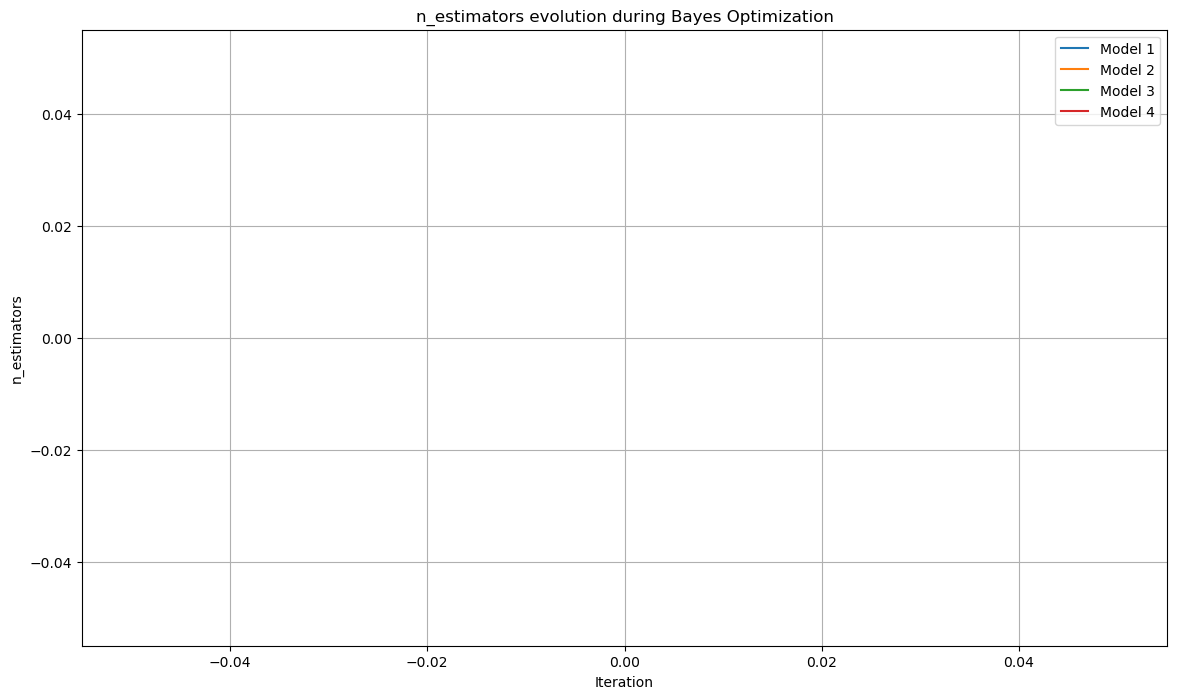

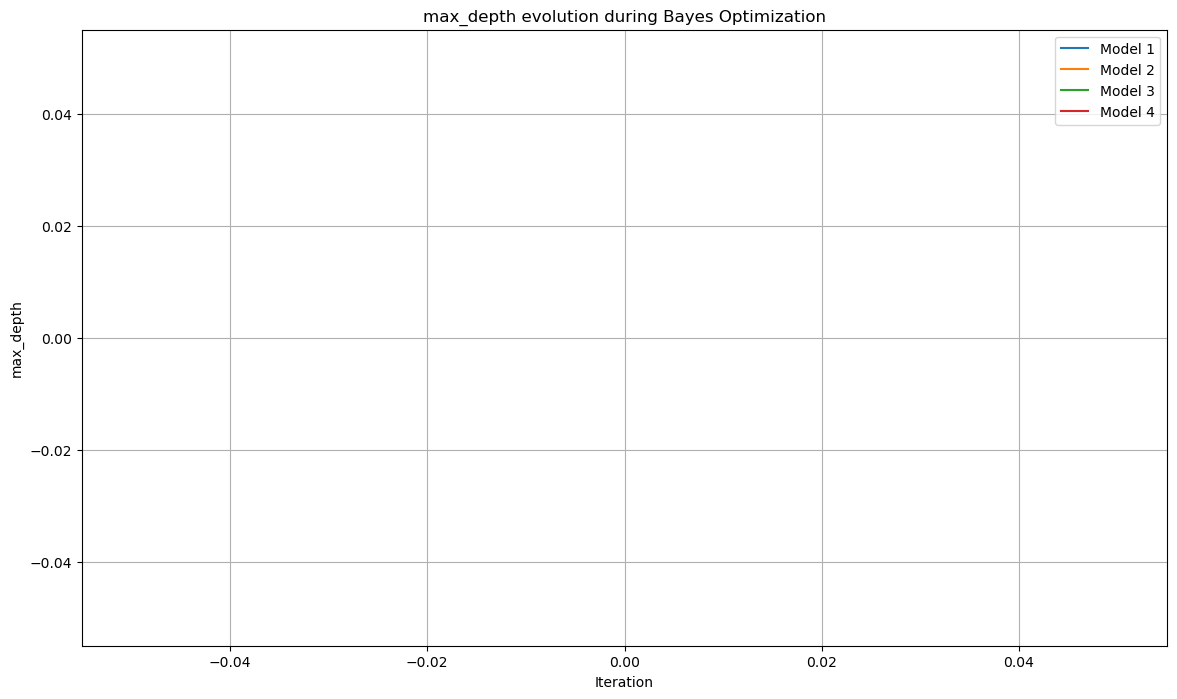

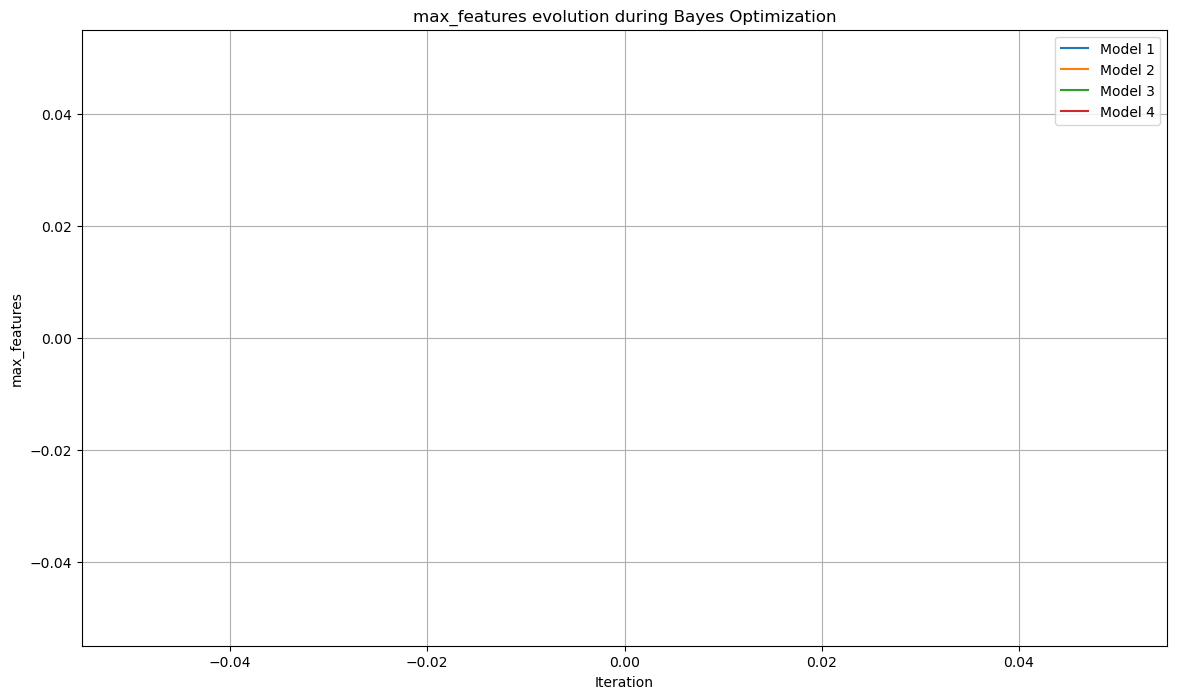

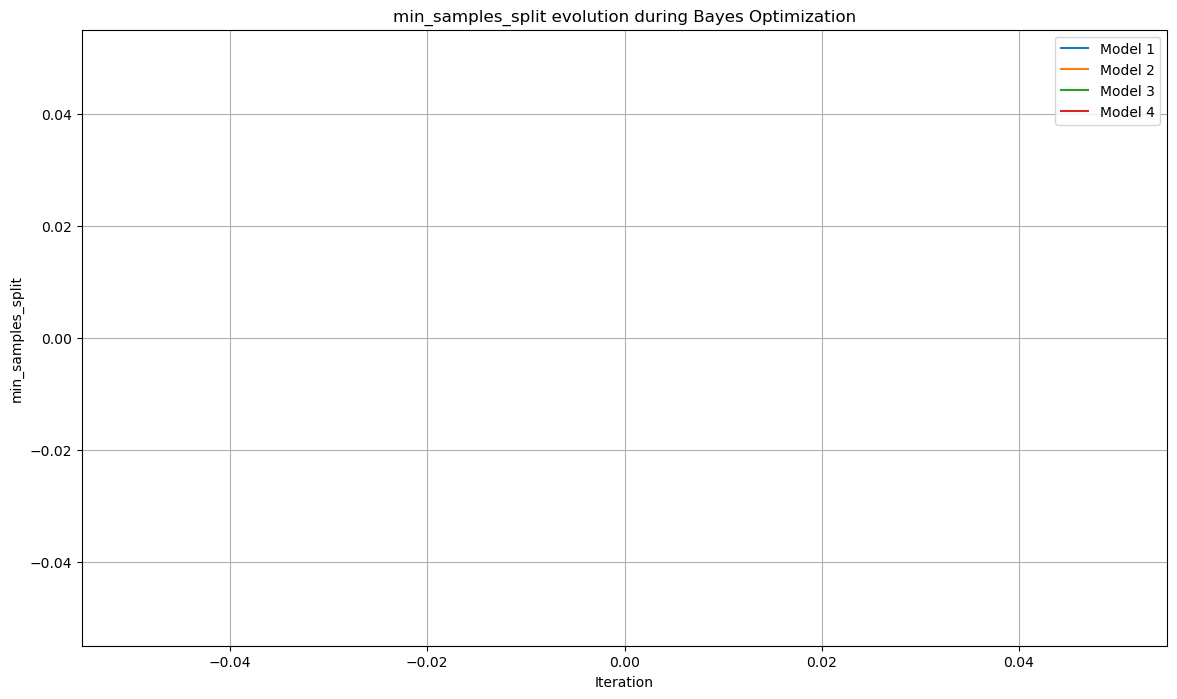

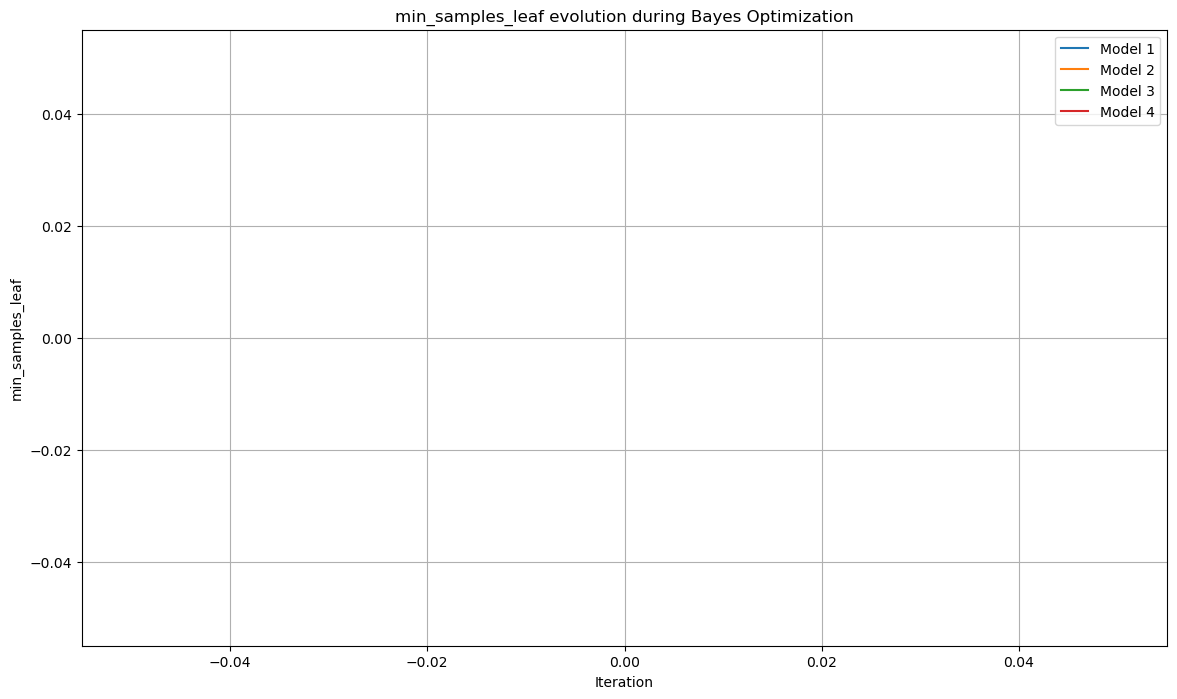

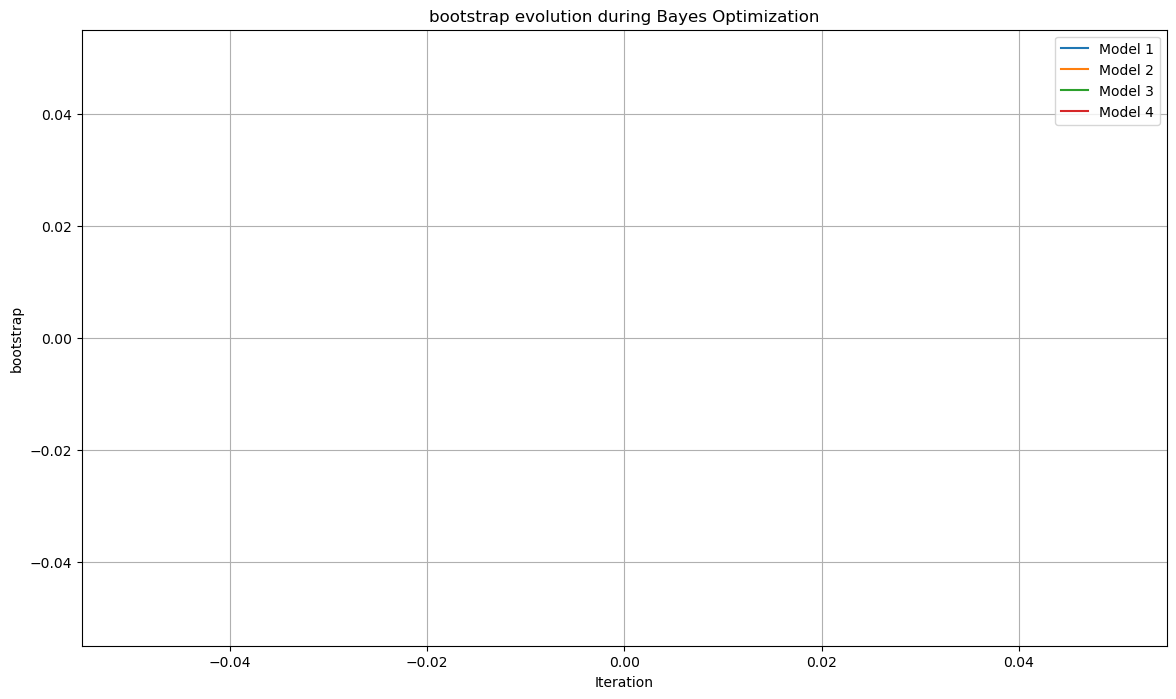

In [94]:
# 参数索引对应到参数名称
param_names = ['n_estimators', 'max_depth', 'max_features', 'min_samples_split', 'min_samples_leaf', 'bootstrap']
param_indices = [0, 1, 2, 3, 4, 5]

# 绘制所有参数的变化
for param_name, param_index in zip(param_names, param_indices):
    plot_param_evolution(all_results, param_name, param_index)

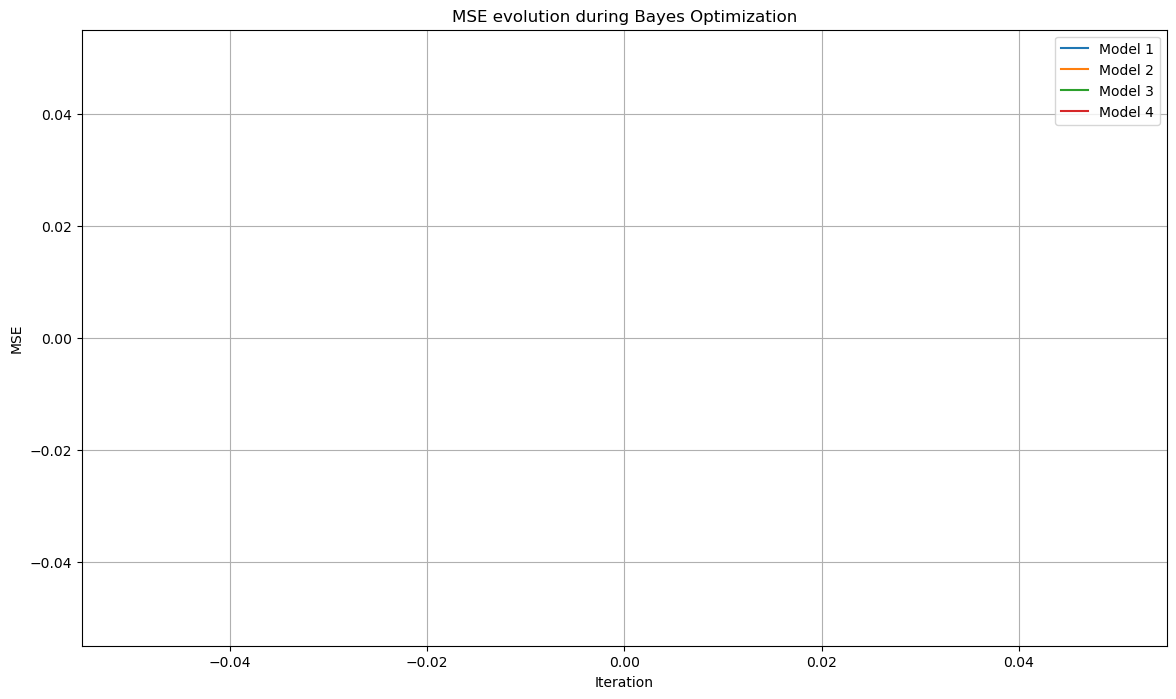

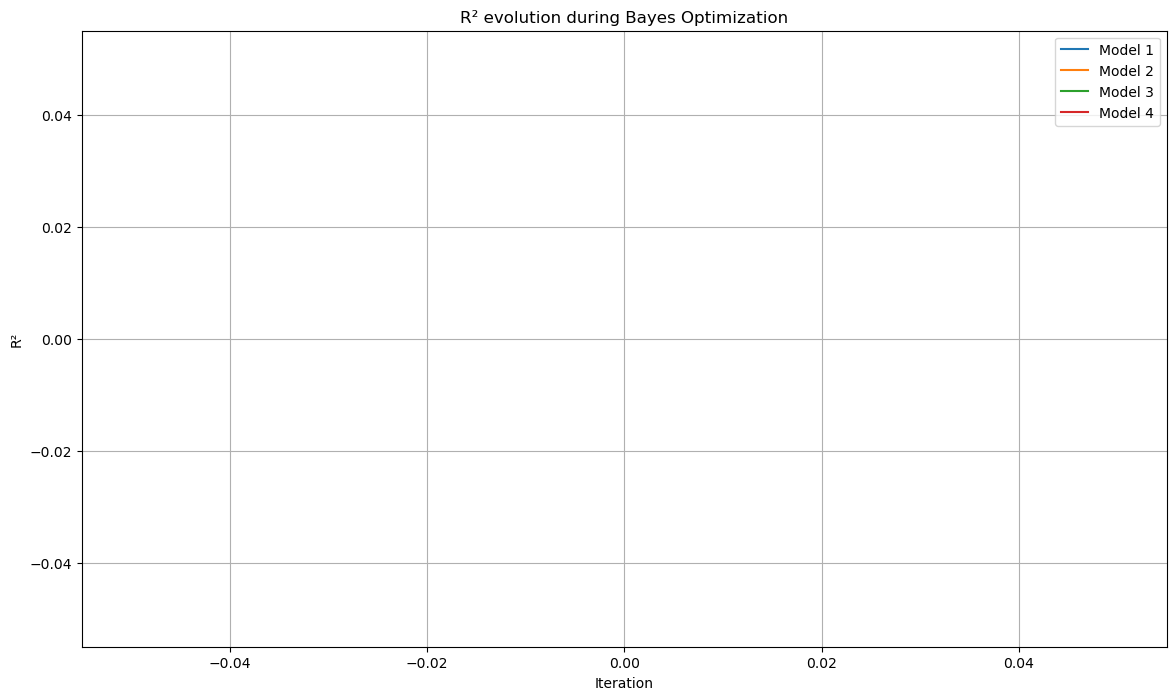

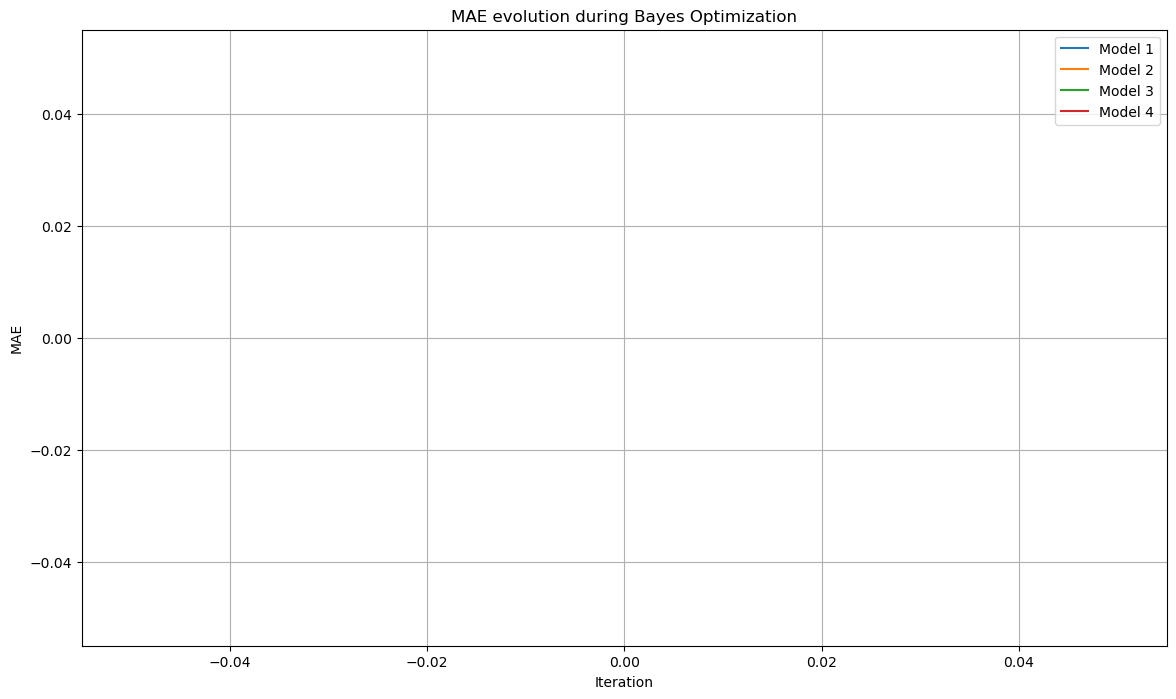

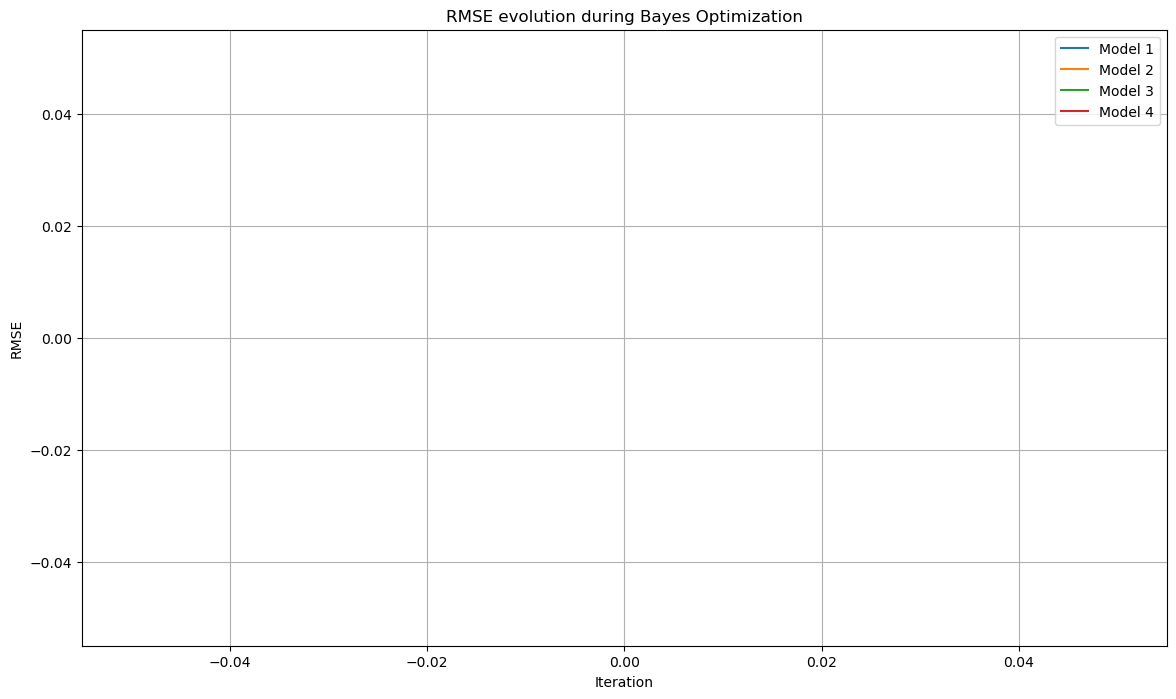

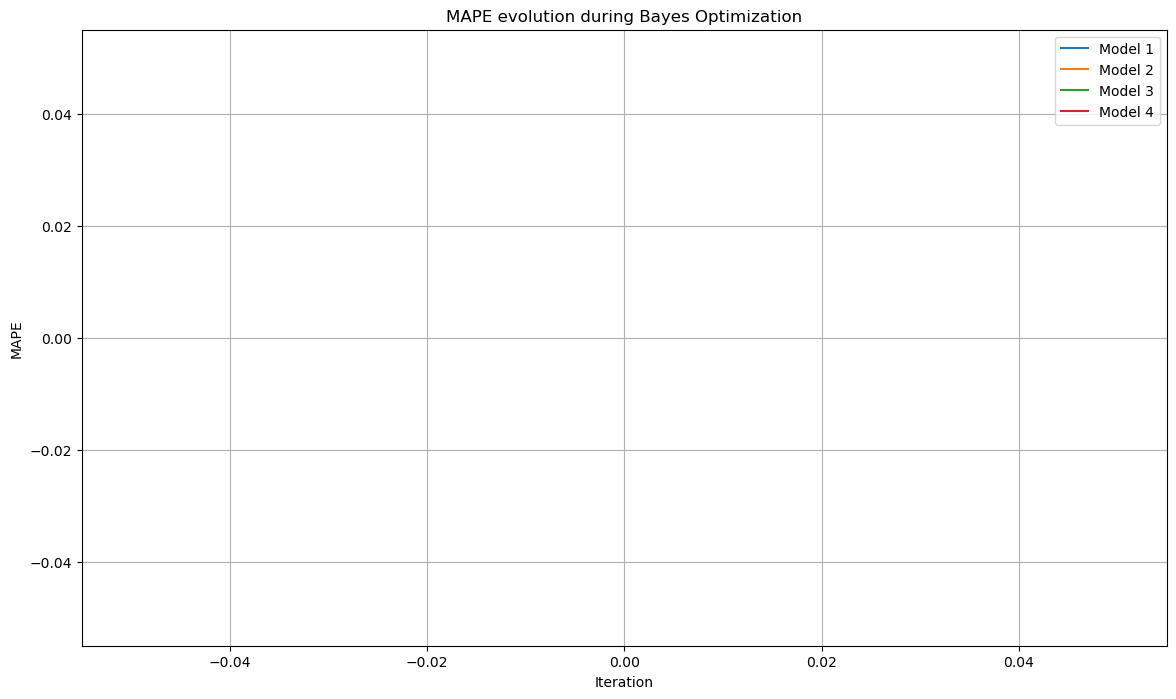

In [95]:
metrics = ['MSE', 'R²', 'MAE', 'RMSE', 'MAPE']
metric_keys = ['mse_scores', 'r2_scores', 'mae_scores', 'rmse_scores', 'mape_scores']

for metric_name, metric_key in zip(metrics, metric_keys):
    plot_metric_evolution(all_results, metric_name, metric_key)


In [96]:
# # 绘制评估指标的变化
# metrics = ['MSE', 'R²', 'MAE', 'RMSE', 'MAPE']
# metric_values = [
#     [result.mse_scores for result in all_results],
#     [result.r2_scores for result in all_results],
#     [result.mae_scores for result in all_results],
#     [result.rmse_scores for result in all_results],
#     [result.mape_scores for result in all_results],
# ]
# 
# for metric_name, metric_value in zip(metrics, metric_values):
#     plot_metric_evolution(all_results, metric_name, metric_value)

In [ ]:
importance_matrix

In [98]:
# 将特征重要性结果转化为DataFrame
importance_df = pd.DataFrame(importance_matrix,
                             columns=['Dew Point (°C)', 'Air Temperature (°C)', 'Relative Humidity (%)', 'Wind Speed (kn)', '?', '?'],
                             index=['建筑物高度', '树冠高度', '叶面积指数', '地形数据'])

print("Feature Importances:")
print(importance_df)

Feature Importances:
       Dew Point (°C)  Air Temperature (°C)  Relative Humidity (%)  \
建筑物高度        0.144381              0.229970               0.175312   
树冠高度         0.154153              0.144556               0.145721   
叶面积指数        0.143244              0.143852               0.155487   
地形数据         0.558222              0.481621               0.523480   

       Wind Speed (kn)    ?    ?  
建筑物高度         0.121744  0.0  0.0  
树冠高度          0.125995  0.0  0.0  
叶面积指数         0.133863  0.0  0.0  
地形数据          0.618398  0.0  0.0  


In [99]:
importance_df

,Dew Point (°C),Air Temperature (°C),Relative Humidity (%),Wind Speed (kn),?,?
建筑物高度,0.144381,0.229970,0.175312,0.121744,0.0,0.0
树冠高度,0.154153,0.144556,0.145721,0.125995,0.0,0.0
叶面积指数,0.143244,0.143852,0.155487,0.133863,0.0,0.0
地形数据,0.558222,0.481621,0.523480,0.618398,0.0,0.0
